In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random
from decimal import Decimal

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib as mpl

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import dataset
import models
import loss
import metrics
import train_epoch
import val_epoch
import utils

# AIMET imports

In [2]:
from aimet_torch.compress import ModelCompressor
from aimet_torch.defs import SpatialSvdParameters
from aimet_torch.onnx_utils import OnnxSaver
from aimet_common.defs import CostMetric, CompressionScheme, GreedySelectionParameters
# from aimet_common.utils import start_bokeh_server_session
# from aimet_torch.visualize_serialized_data import VisualizeCompression

# import nest_asyncio # To run de bokeh server

2024-07-06 08:40:09,432 - root - INFO - AIMET


In [3]:
# nest_asyncio.apply() # Enable nested loops to start bokeh server

In [4]:
#torch.cuda.empty_cache()

# Define Matplot Style

In [5]:
mpl.style.use('seaborn-v0_8')

# Logger

In [6]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tAdding best mean F1 save.\n' +
            '\t256 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            f'\tSVD Compression Ratio  = {config.SVD_COMPRESSION_RATIO}\n' +
            f'\t{config.EPOCHS} epochs.\n')

# View Dataset

### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

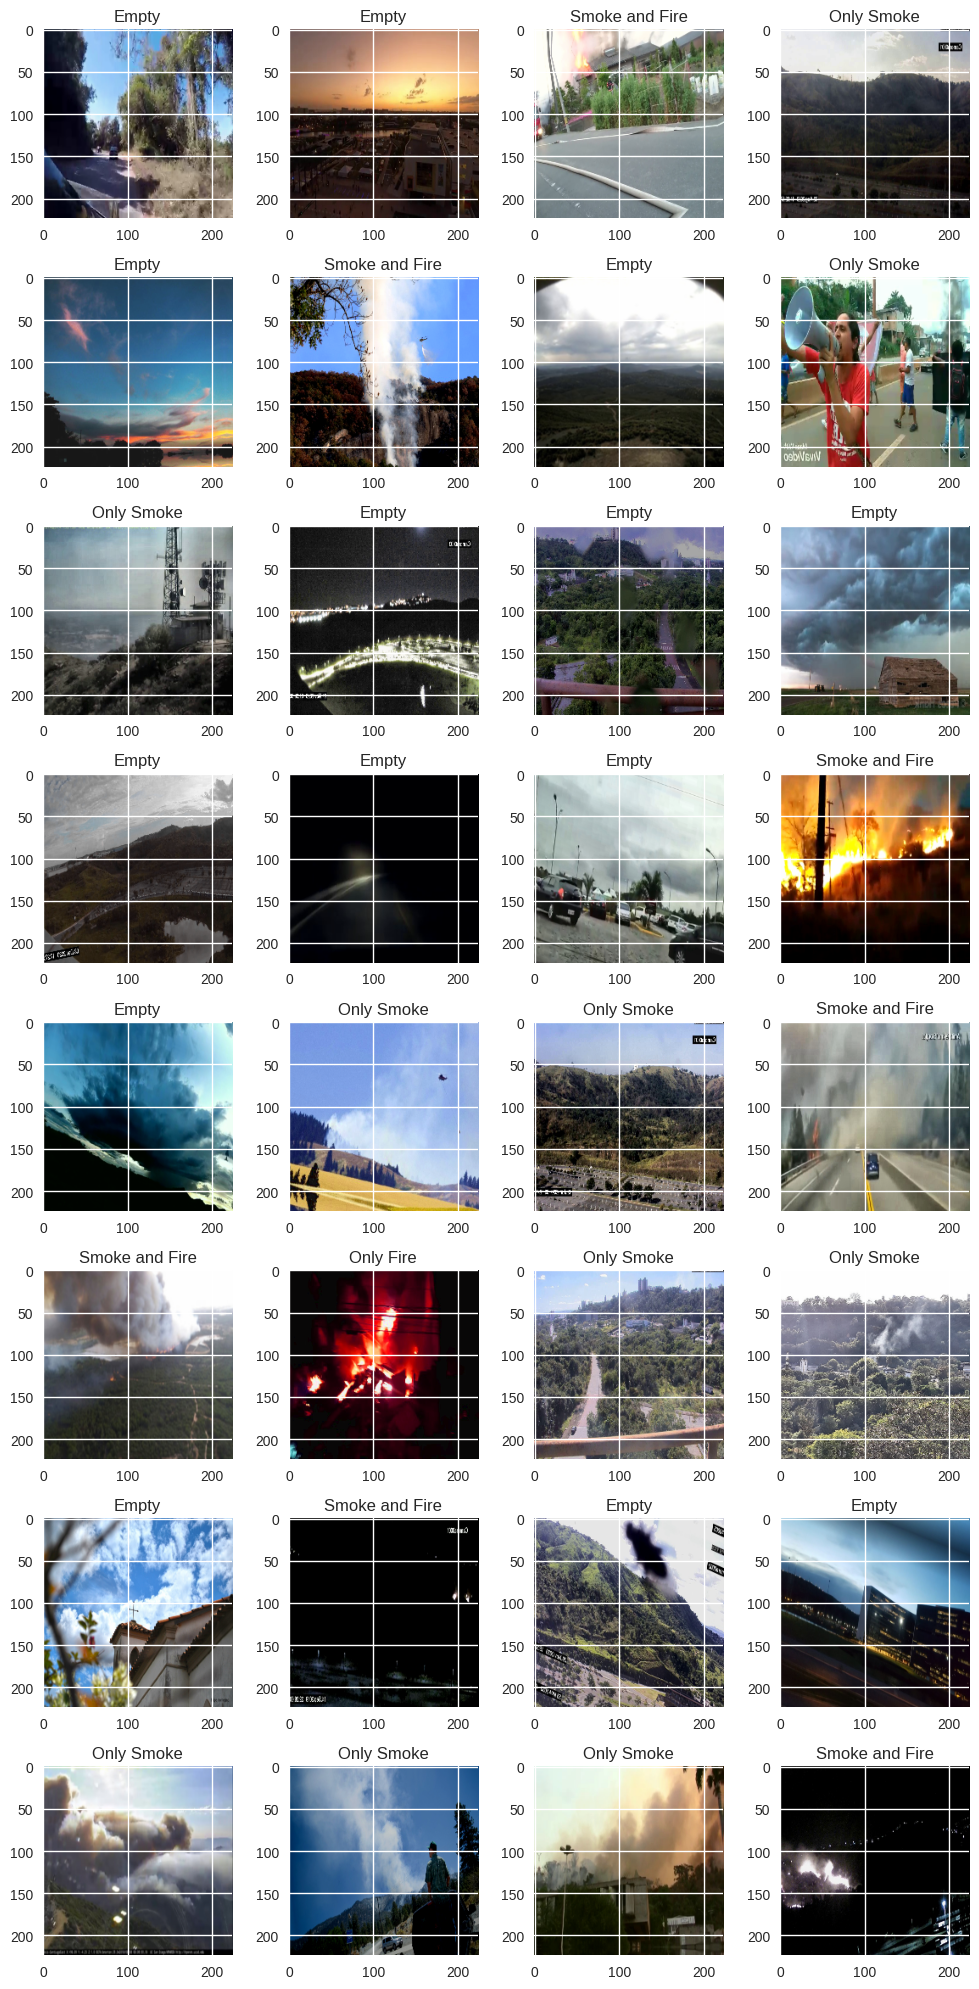

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [10]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Models Setup

In [11]:
if config.MODEL == "BED":   
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models.FUSED_BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in fp32_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(fp32_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier

Trainable parameters = 92786
Total parameters = 92786



### Check Model Shape

In [12]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = fp32_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{fp32_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{fp32_model}')

Model shape is tensor([[-0.1786, -0.0279],
        [-0.1816, -0.0173],
        [-0.1883, -0.0162],
        [-0.1786, -0.0256]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
FUSED_BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu31): ReLU()
    (conv32): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu32): ReLU()
    (conv33): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (relu33): ReLU()
    (conv34): C

# Load Pretrained or Initialize Weights

In [13]:
epochs_trained = utils.load_checkpoint(config.LOAD_MODEL_FILE, 
                                       fp32_model, 
                                       optimizer=None, 
                                       scheduler=None, 
                                       device=config.DEVICE)

logger.info(f"Loading Model. Trained during {epochs_trained} epochs")

Loading Model. Trained during 127 epochs


# Torchinfo: model summary

In [14]:
print(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))
logger.info("Original FP32 Model Summary")
logger.info(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
FUSED_BED_CLASSIFIER                     [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─ReLU: 2-2                         [1, 32, 224, 224]         --
│    └─Dropout2d: 2-3                    [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 32, 112, 112]         --
│    └─Conv2d: 2-5                       [1, 16, 112, 112]         4,624
│    └─ReLU: 2-6                         [1, 16, 112, 112]         --
│    └─Dropout2d: 2-7                    [1, 16, 112, 112]         --
│    └─MaxPool2d: 2-8                    [1, 16, 56, 56]           --
│    └─Conv2d: 2-9                       [1, 16, 56, 56]           272
│    └─ReLU: 2-10                        [1, 16, 56, 56]           --
│    └─Conv2d: 2-11                      [1, 32, 56, 56]           4,640
│    └─

# Save ONNX original model

In [15]:
input_shape = (1, 3, config.IMG_H, config.IMG_W)

torch.onnx.export(fp32_model, torch.randn(input_shape).to(config.DEVICE), config.RUN_FOLDER + 'fp32_model.onnx')
#OnnxSaver.set_node_names('/models/fp32_model.onnx', fp32_model, input_shape)

# AIMET Spatial SVD

### Start Visualization Server

In [16]:
# visualization_url, process = start_bokeh_server_session()
# print(visualization_url)

### Configure SVD Parameters

In [17]:
#modules_to_ignore = [model.conv1]
modules_to_ignore = []
greedy_params = GreedySelectionParameters(target_comp_ratio=Decimal(config.SVD_COMPRESSION_RATIO), 
                                          saved_eval_scores_dict=config.SVD_DIC_FILE)
auto_params = SpatialSvdParameters.AutoModeParams(greedy_params,
                                                  modules_to_ignore=modules_to_ignore)
spatial_svd_params = SpatialSvdParameters(mode=SpatialSvdParameters.Mode.auto,
                                          params=auto_params)

### Evaluate Model Callback

Signature: (model, iterations, use_cuda)
Return an accuracy metric

In [18]:
def evaluate_model(model, iterations, use_cuda):
    
    model.eval()

    for batch_idx, (x, y) in enumerate(val_loader):
        if use_cuda == True:
            x, y = x.to('cuda'), y.to('cuda')
        else:
            model.to('cpu')
        out = model(x)
        if iterations is not None:
            if batch_idx == iterations:
                break
        
        # F1 average Macro   
        yhat = torch.sigmoid(out.detach())
        metrics.f1_metric_mean.update(yhat, y)
    
    f1_mean = metrics.f1_metric_mean.compute()
    metrics.f1_metric_mean.reset()

    print(f'F1 mean: {f1_mean:.4f}')
    
    return f1_mean.item()

### Baseline F1 Mean

In [19]:
baseline_f1 = evaluate_model(fp32_model, None, True)
print(type(baseline_f1))

F1 mean: 0.9183
<class 'float'>


In [20]:
comp_model, stats = ModelCompressor.compress_model(fp32_model,
                                                   input_shape=input_shape,
                                                   eval_callback=evaluate_model,
                                                   eval_iterations=None,
                                                   compress_scheme=CompressionScheme.spatial_svd,
                                                   cost_metric=CostMetric.memory,
                                                   parameters=spatial_svd_params,
                                                   visualization_url=None)                                                    

2024-07-06 08:41:50,740 - CompRatioSelect - INFO - Analyzing compression ratio: 0.1 =====================>
2024-07-06 08:41:50,742 - Svd - INFO - Spatial SVD splitting layer: model.conv1 using rank: 1
F1 mean: 0.4204
2024-07-06 08:41:54,181 - CompRatioSelect - INFO - Layer model.conv1, comp_ratio 0.100000 ==> eval_score=0.420372
2024-07-06 08:41:54,181 - CompRatioSelect - INFO - Analyzing compression ratio: 0.2 =====================>
2024-07-06 08:41:54,183 - Svd - INFO - Spatial SVD splitting layer: model.conv1 using rank: 1
F1 mean: 0.4204
2024-07-06 08:41:57,649 - CompRatioSelect - INFO - Layer model.conv1, comp_ratio 0.200000 ==> eval_score=0.420372
2024-07-06 08:41:57,650 - CompRatioSelect - INFO - Analyzing compression ratio: 0.3 =====================>
2024-07-06 08:41:57,652 - Svd - INFO - Spatial SVD splitting layer: model.conv1 using rank: 2
F1 mean: 0.5414
2024-07-06 08:42:01,125 - CompRatioSelect - INFO - Layer model.conv1, comp_ratio 0.300000 ==> eval_score=0.541449
2024-07

In [21]:
print(comp_model)
logger.info(comp_model)

FUSED_BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Sequential(
      (0): Conv2d(32, 9, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
      (1): Conv2d(9, 16, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    )
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu31): ReLU()
    (conv32): Sequential(
      (0): Conv2d(16, 28, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
      (1): Conv2d(28, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    )
    (relu32): ReLU()
    (conv33): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 

### Print Stats

In [22]:
print(stats)
logger.info(stats)

**********************************************************************************************
Compressed Model Statistics
Baseline model accuracy: 0.918301, Compressed model accuracy: 0.917511
Compression ratio for memory=0.795596, mac=0.755784

**********************************************************************************************

Per-layer Stats
    Name:model.conv1, compression-ratio: None
    Name:model.conv2, compression-ratio: 0.3
    Name:model.conv31, compression-ratio: None
    Name:model.conv32, compression-ratio: 0.9
    Name:model.conv33, compression-ratio: None
    Name:model.conv34, compression-ratio: None
    Name:model.conv41, compression-ratio: None
    Name:model.conv42, compression-ratio: None
    Name:model.conv43, compression-ratio: None
    Name:model.conv44, compression-ratio: None
    Name:model.conv45, compression-ratio: None
    Name:model.conv46, compression-ratio: 0.2

*********************************************************************************

### Torchinfo: model compressed summary

In [23]:
print(summary(comp_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info("Compressed Model Summary")
logger.info(summary(comp_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
FUSED_BED_CLASSIFIER                     [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        896
│    └─ReLU: 2-2                         [64, 32, 224, 224]        --
│    └─Dropout2d: 2-3                    [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-4                    [64, 32, 112, 112]        --
│    └─Sequential: 2-5                   [64, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [64, 9, 112, 112]         864
│    │    └─Conv2d: 3-2                  [64, 16, 112, 112]        448
│    └─ReLU: 2-6                         [64, 16, 112, 112]        --
│    └─Dropout2d: 2-7                    [64, 16, 112, 112]        --
│    └─MaxPool2d: 2-8                    [64, 16, 56, 56]          --
│    └─Conv2d: 2-9                       [64, 16, 56, 56]          272
│    └─ReLU

### Evaluate Compressed Model

In [24]:
comp_f1 = evaluate_model(comp_model, None, True)

F1 mean: 0.9175


### Visualize Results

In [25]:
comp_ratios_file_path = './data/greedy_selection_comp_ratios_list.pkl'
eval_scores_path = './data/greedy_selection_eval_scores_dict.pkl'

unpickled_ratios = pd.read_pickle(comp_ratios_file_path)
unpickled_scores = pd.read_pickle(eval_scores_path)

In [26]:
df_scores = pd.DataFrame(unpickled_scores)
df_scores.to_csv(config.RUN_FOLDER + 'scores.csv')
print(df_scores)

     model.conv1  model.conv2  model.conv31  model.conv32  model.conv33  \
0.1     0.420372     0.873229      0.663141      0.329864      0.000000   
0.2     0.420372     0.915431      0.663141      0.853478      0.329427   
0.3     0.541449     0.918100      0.664087      0.872589      0.488561   
0.4     0.656327     0.918884      0.689465      0.910388      0.555859   
0.5     0.700673     0.918274      0.711022      0.916755      0.890500   
0.6     0.700673     0.918020      0.711022      0.918910      0.893901   
0.7     0.790278     0.918202      0.760484      0.916421      0.899899   
0.8     0.771718     0.917804      0.906438      0.914278      0.897074   
0.9     0.895517     0.918230      0.915513      0.918219      0.909510   

     model.conv34  model.conv41  model.conv42  model.conv43  model.conv44  \
0.1      0.383353      0.164418      0.645156      0.553236      0.301559   
0.2      0.805782      0.110005      0.767354      0.568418      0.437752   
0.3      0.889608 

In [27]:
df_ratios = pd.DataFrame(unpickled_ratios)
df_ratios.to_csv(config.RUN_FOLDER + 'ratios.csv')
print(df_ratios)

               0     1
0    model.conv1  None
1    model.conv2   0.3
2   model.conv31  None
3   model.conv32   0.9
4   model.conv33  None
5   model.conv34  None
6   model.conv41  None
7   model.conv42  None
8   model.conv43  None
9   model.conv44  None
10  model.conv45  None
11  model.conv46   0.2


# Save Compressed Before Training

In [28]:
torch.onnx.export(comp_model, torch.randn(input_shape).to(config.DEVICE), config.RUN_FOLDER + 'comp_model_noTrain.onnx')

### Optimizer and Scheduler of Compressed Model to Train

In [29]:
optimizer = optim.Adam(comp_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

utils.save_checkpoint(epoch=0, 
                      model=comp_model,
                      optimizer=optimizer,
                      scheduler=scheduler,
                      checkpoint_name=config.WEIGHTS_FOLDER + 'comp_model_after_svd.pt')

# Loss Function

In [30]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [31]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.0001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [32]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Train Loop Function

In [33]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])
    best_mean_f1 = 0.

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 

        # Save model if best mean F1 increases
        val_f1_mean = (val_metrics['F1'][0] + val_metrics['F1'][1]) / 2
        if (val_f1_mean > best_mean_f1) :
            best_mean_f1 = val_f1_mean
            print(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            logger.info(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            save_f1_name = 'best_mean_F1'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_f1_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Training

In [34]:
print("Start Training\n")
logger.info("Start Training\n")

trained_model = train_loop(comp_model)

Start Training


***Start Training: 08:48:17


=== EPOCH 0/19 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.187      |15.861      |7.327       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.618      |13.571      |7.047       
SMOKE -> Precision: 0.897 - Recall: 0.918 - Accuracy: 0.910 - F1: 0.908
FIRE -> Precision: 0.942 - Recall: 0.906 - Accuracy: 0.961 - F1: 0.924

Saving model with new best validation loss: 20.618

Saving model with new best smoke precision: 0.897
Saving model with best Mean F1: 0.9157

=== EPOCH 1/19 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.808      |15.658      |7.150       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.881      |13.897      |6.984       
SMOKE -> Precision: 0.912 - Recall: 0.899 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.945 - Recall: 0.911 - Accuracy: 0.963 - F1: 0.928

Saving model with new best smoke precision: 0.912
Saving model with best Mean F1: 0.9166

=== EPOCH 2/19 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.815      |15.811      |7.003       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.533      |14.592      |6.941       
SMOKE -> Precision: 0.876 - Recall: 0.937 - Accuracy: 0.906 - F1: 0.906
FIRE -> Precision: 0.947 - Recall: 0.910 - Accuracy: 0.964 - F1: 0.928
Saving model with best Mean F1: 0.9171

=== EPOCH 3/19 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.781      |15.837      |6.944       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.396      |14.572      |7.824       
SMOKE -> Precision: 0.928 - Recall: 0.854 - Accuracy: 0.898 - F1: 0.889
FIRE -> Precision: 0.968 - Recall: 0.878 - Accuracy: 0.961 - F1: 0.921

=== EPOCH 4/19 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.744      |15.508      |7.235       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.195      |13.823      |7.373       
SMOKE -> Precision: 0.913 - Recall: 0.890 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.957 - Recall: 0.893 - Accuracy: 0.962 - F1: 0.924

Saving model with new best smoke precision: 0.913

=== EPOCH 5/19 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.461      |15.474      |6.986       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.379      |13.387      |6.992       
SMOKE -> Precision: 0.912 - Recall: 0.900 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.950 - Recall: 0.899 - Accuracy: 0.962 - F1: 0.924

Saving model with new best validation loss: 20.379

=== EPOCH 6/19 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.296      |15.216      |7.080       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.189      |14.121      |7.068       
SMOKE -> Precision: 0.924 - Recall: 0.872 - Accuracy: 0.904 - F1: 0.897
FIRE -> Precision: 0.943 - Recall: 0.908 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 7/19 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.552      |15.650      |6.903       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.979      |13.682      |7.297       
SMOKE -> Precision: 0.903 - Recall: 0.911 - Accuracy: 0.910 - F1: 0.907
FIRE -> Precision: 0.956 - Recall: 0.892 - Accuracy: 0.961 - F1: 0.923

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 8/19 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.218      |15.418      |6.800       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.212      |13.838      |7.374       
SMOKE -> Precision: 0.895 - Recall: 0.921 - Accuracy: 0.910 - F1: 0.908
FIRE -> Precision: 0.958 - Recall: 0.894 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 9/19 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.685      |15.044      |6.641       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.592      |14.233      |7.360       
SMOKE -> Precision: 0.927 - Recall: 0.862 - Accuracy: 0.901 - F1: 0.894
FIRE -> Precision: 0.955 - Recall: 0.899 - Accuracy: 0.963 - F1: 0.926

=== EPOCH 10/19 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.201      |15.395      |6.806       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.865      |13.591      |7.274       
SMOKE -> Precision: 0.911 - Recall: 0.908 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.951 - Recall: 0.899 - Accuracy: 0.962 - F1: 0.925

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 11/19 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.781      |14.744      |7.038       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.518      |13.622      |6.896       
SMOKE -> Precision: 0.910 - Recall: 0.904 - Accuracy: 0.910 - F1: 0.907
FIRE -> Precision: 0.936 - Recall: 0.914 - Accuracy: 0.962 - F1: 0.925

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 12/19 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.626      |14.753      |6.874       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.683      |13.518      |7.166       
SMOKE -> Precision: 0.914 - Recall: 0.905 - Accuracy: 0.914 - F1: 0.910
FIRE -> Precision: 0.952 - Recall: 0.897 - Accuracy: 0.962 - F1: 0.924

Saving model with new best smoke precision: 0.914

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 13/19 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.717      |14.990      |6.727       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.106      |15.655      |7.451       
SMOKE -> Precision: 0.932 - Recall: 0.838 - Accuracy: 0.893 - F1: 0.883
FIRE -> Precision: 0.955 - Recall: 0.900 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 14/19 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.421      |14.829      |6.592       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.399      |13.506      |6.893       
SMOKE -> Precision: 0.912 - Recall: 0.908 - Accuracy: 0.913 - F1: 0.910
FIRE -> Precision: 0.943 - Recall: 0.914 - Accuracy: 0.963 - F1: 0.928

Saving model with precision > 0.9 and recall > 0.9
Saving model with best Mean F1: 0.9190

=== EPOCH 15/19 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.647      |15.030      |6.618       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.157      |13.247      |6.910       
SMOKE -> Precision: 0.910 - Recall: 0.917 - Accuracy: 0.917 - F1: 0.914
FIRE -> Precision: 0.942 - Recall: 0.913 - Accuracy: 0.963 - F1: 0.927

Saving model with new best validation loss: 20.157

Saving model with precision > 0.9 and recall > 0.9
Saving model with best Mean F1: 0.9205

=== EPOCH 16/19 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.650      |14.835      |6.816       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.131      |14.064      |7.067       
SMOKE -> Precision: 0.928 - Recall: 0.869 - Accuracy: 0.904 - F1: 0.897
FIRE -> Precision: 0.952 - Recall: 0.904 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 17/19 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.452      |14.740      |6.712       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.282      |13.386      |6.896       
SMOKE -> Precision: 0.918 - Recall: 0.896 - Accuracy: 0.912 - F1: 0.907
FIRE -> Precision: 0.944 - Recall: 0.914 - Accuracy: 0.964 - F1: 0.929

Saving model with new best smoke precision: 0.918

=== EPOCH 18/19 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.365      |14.708      |6.658       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.739      |14.128      |7.611       
SMOKE -> Precision: 0.928 - Recall: 0.871 - Accuracy: 0.905 - F1: 0.898
FIRE -> Precision: 0.962 - Recall: 0.885 - Accuracy: 0.961 - F1: 0.922

=== EPOCH 19/19 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|██████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.300      |14.731      |6.569       



Validating: 100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.865      |13.595      |7.271       
SMOKE -> Precision: 0.913 - Recall: 0.906 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.959 - Recall: 0.903 - Accuracy: 0.965 - F1: 0.930

Saving model with precision > 0.9 and recall > 0.9

***Script finished: 08:57:20

Time elapsed: 0:09:02.596708


# Check Comp Model Params

In [35]:
# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in comp_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = sum(p.numel() for p in comp_model.parameters())
print(f'Total parameters = {n_params}')
logger.info(f'Total parameters = {n_params}\n')


Trainable parameters = 73922
Total parameters = 73922


# Export to ONNX

In [36]:
torch.onnx.export(trained_model, torch.randn(input_shape).to(config.DEVICE), config.RUN_FOLDER + 'comp_model_Train.onnx')
#OnnxSaver.set_node_names('/models/fp32_model.onnx', trained_model, input_shape)